In [1]:
# 下载中文字体
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

--2022-11-07 10:26:55--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在解析主机 zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
正在连接 zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：10050868 (9.6M) [application/x-font-ttf]
正在保存至: “SimHei.ttf.1”

SimHei.ttf.1        100%[===================>]   9.58M  40.3MB/s  用时 0.2s      

2022-11-07 10:27:00 (40.3 MB/s) - 已保存 “SimHei.ttf.1” [10050868/10050868])



### 创建文件

- 结果文件：`output`
- 存放预训练得到的权重和文件：`checkpoints`
- 存放生成的图表：`graph`

In [2]:
import os 
os.mkdir('../Demo_zihao')
os.mkdir('../Demo_zihao/output')
os.mkdir('../Demo_zihao/checkpoints')
os.mkdir('../Demo_zihao/graph')

FileExistsError: [Errno 17] File exists: '../Demo_zihao'

#### 设置matplotlib中文字体

In [1]:
!rm -rf /home/featurize/.cache/matplotlib
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rc("font",family='SimHei') # 中文字体
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [79]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

In [15]:
!ls /home/Datasets/FGVC/CUB/images

001.Black_footed_Albatross     101.White_Pelican
002.Laysan_Albatross	       102.Western_Wood_Pewee
003.Sooty_Albatross	       103.Sayornis
004.Groove_billed_Ani	       104.American_Pipit
005.Crested_Auklet	       105.Whip_poor_Will
006.Least_Auklet	       106.Horned_Puffin
007.Parakeet_Auklet	       107.Common_Raven
008.Rhinoceros_Auklet	       108.White_necked_Raven
009.Brewer_Blackbird	       109.American_Redstart
010.Red_winged_Blackbird       110.Geococcyx
011.Rusty_Blackbird	       111.Loggerhead_Shrike
012.Yellow_headed_Blackbird    112.Great_Grey_Shrike
013.Bobolink		       113.Baird_Sparrow
014.Indigo_Bunting	       114.Black_throated_Sparrow
015.Lazuli_Bunting	       115.Brewer_Sparrow
016.Painted_Bunting	       116.Chipping_Sparrow
017.Cardinal		       117.Clay_colored_Sparrow
018.Spotted_Catbird	       118.House_Sparrow
019.Gray_Catbird	       119.Field_Sparrow
020.Yellow_breasted_Chat       120.Fox_Sparrow
021.Eastern_Towhee	       121.Grasshopper_Sparrow
022.Chuck_will_Wi

#### 图像预处理


In [21]:
from torchvision import transforms,datasets

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

#### 载入图像分类数据集

In [94]:
train_path = '/home/Datasets/FGVC/CUB/train'
val_path = '/home/Datasets/FGVC/CUB/test'

#### 图像分类(按类别标签分)

In [96]:
imgs_list = os.listdir(train_path)
# imgs_list ['cat.3238.jpg', 'cat.1092.jpg', 'dog.414.jpg', 'dog.7643.jpg', 
#            'dog.1128.jpg', 'dog.3042.jpg', 'dog.3167.jpg', 
#            'cat.9994.jpg', 'dog.10287.jpg', 'dog.8280.jpg', 'dog.1179.jpg', 
#           'cat.1166.jpg', 'dog.2578.jpg', 'cat.256.jpg', 'dog.9077.jpg', 
#           'cat.11565.jpg', 'dog.4665.jpg',]
                    
# for i in imgs_list:
#     # 创建猫狗文件夹
#     #os.mkdir(os.path.join(train_path,'dog'))
#     #os.mkdir(os.path.join(train_path,'cat'))
#     if 'dog' in i:
#         tmp_path = os.path.join(train_path,i)
#         dist_path = os.path.join(train_path,'dog')
#         os.rename(tmp_path,os.path.join(dist_path,i))
#     elif 'cat'in i:
#         tmp_path = os.path.join(train_path,i)
#         dist_path = os.path.join(train_path,'cat')
#         os.rename(tmp_path,os.path.join(dist_path,i))
#     else:
#         print(i)

#### 载入图像


In [99]:
train_dataset = datasets.ImageFolder(train_path,train_transform)
# 测试集合未区分dog/cat
val_dataset = datasets.ImageFolder(val_path,train_transform)

print('测试集数量',len(train_dataset))
print('类别数量',len(train_dataset.classes))
# 通过数据集的.classes来获取类别
print('各个类别的名称',train_dataset.classes)

print('验证集数量',len(val_dataset))
print('类别数量',len(val_dataset.classes))
print('各个类别的名称',val_dataset.classes)

测试集数量 8284
类别数量 200
各个类别的名称 ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_

#### 键值对一一对应

In [100]:
# 映射关系： 类别-->索引号
train_dataset.class_to_idx

{'001.Black_footed_Albatross': 0,
 '002.Laysan_Albatross': 1,
 '003.Sooty_Albatross': 2,
 '004.Groove_billed_Ani': 3,
 '005.Crested_Auklet': 4,
 '006.Least_Auklet': 5,
 '007.Parakeet_Auklet': 6,
 '008.Rhinoceros_Auklet': 7,
 '009.Brewer_Blackbird': 8,
 '010.Red_winged_Blackbird': 9,
 '011.Rusty_Blackbird': 10,
 '012.Yellow_headed_Blackbird': 11,
 '013.Bobolink': 12,
 '014.Indigo_Bunting': 13,
 '015.Lazuli_Bunting': 14,
 '016.Painted_Bunting': 15,
 '017.Cardinal': 16,
 '018.Spotted_Catbird': 17,
 '019.Gray_Catbird': 18,
 '020.Yellow_breasted_Chat': 19,
 '021.Eastern_Towhee': 20,
 '022.Chuck_will_Widow': 21,
 '023.Brandt_Cormorant': 22,
 '024.Red_faced_Cormorant': 23,
 '025.Pelagic_Cormorant': 24,
 '026.Bronzed_Cowbird': 25,
 '027.Shiny_Cowbird': 26,
 '028.Brown_Creeper': 27,
 '029.American_Crow': 28,
 '030.Fish_Crow': 29,
 '031.Black_billed_Cuckoo': 30,
 '032.Mangrove_Cuckoo': 31,
 '033.Yellow_billed_Cuckoo': 32,
 '034.Gray_crowned_Rosy_Finch': 33,
 '035.Purple_Finch': 34,
 '036.Norther

In [101]:
# 映射关系： 索引号-->类别
idx_to_labels ={y:x for x,y in train_dataset.class_to_idx.items()}
idx_to_labels

{0: '001.Black_footed_Albatross',
 1: '002.Laysan_Albatross',
 2: '003.Sooty_Albatross',
 3: '004.Groove_billed_Ani',
 4: '005.Crested_Auklet',
 5: '006.Least_Auklet',
 6: '007.Parakeet_Auklet',
 7: '008.Rhinoceros_Auklet',
 8: '009.Brewer_Blackbird',
 9: '010.Red_winged_Blackbird',
 10: '011.Rusty_Blackbird',
 11: '012.Yellow_headed_Blackbird',
 12: '013.Bobolink',
 13: '014.Indigo_Bunting',
 14: '015.Lazuli_Bunting',
 15: '016.Painted_Bunting',
 16: '017.Cardinal',
 17: '018.Spotted_Catbird',
 18: '019.Gray_Catbird',
 19: '020.Yellow_breasted_Chat',
 20: '021.Eastern_Towhee',
 21: '022.Chuck_will_Widow',
 22: '023.Brandt_Cormorant',
 23: '024.Red_faced_Cormorant',
 24: '025.Pelagic_Cormorant',
 25: '026.Bronzed_Cowbird',
 26: '027.Shiny_Cowbird',
 27: '028.Brown_Creeper',
 28: '029.American_Crow',
 29: '030.Fish_Crow',
 30: '031.Black_billed_Cuckoo',
 31: '032.Mangrove_Cuckoo',
 32: '033.Yellow_billed_Cuckoo',
 33: '034.Gray_crowned_Rosy_Finch',
 34: '035.Purple_Finch',
 35: '036.Nor

**将键值对保存到本地**

In [102]:
np.save('idx_to_labels.npy',idx_to_labels)
np.save('labels_to_label.npy',train_dataset.class_to_idx)

#### 定义数据加载器

In [122]:
from torch.utils.data import DataLoader
Batch_size=200
# 训练数据集加载器
train_loader = DataLoader(train_dataset,
                         batch_size=Batch_size,
                         shuffle=True,
                         num_workers=4)

# 测试数据集加载器
val_loader = DataLoader(val_dataset,
                         batch_size=Batch_size,
                         shuffle=True,
                         num_workers=4)


#### 查看一个标注和图像

In [109]:
# 每次调用返回一个batch 的数据
imgs,labels = next(iter(train_loader))
print(imgs.shape)
print(['batch_size,channel,width,height'])

torch.Size([200, 3, 224, 224])
['batch_size,channel,width,height']


#### 可视化一个batch的图像和标注

In [106]:
# 转为 numpy格式
imgs = imgs.numpy()
# 显示第一张图片的shape
imgs[0].shape

(3, 224, 224)

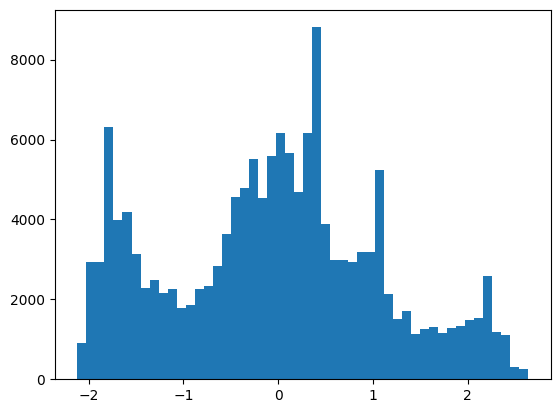

In [107]:
# 绘制像素的直方图
plt.hist(imgs[0].flatten(),bins=50)
plt.show()

### 选择迁移学习的方式

#### method 1
只微调训练模型最后一层(全连接分类层)

In [20]:
from torchvision import models
import torchvision
import torch
n_class = 200
# 选择 resnet18 作为预训练模型
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
x = torch.ones(1,3,224,224)

for name, variable in model.named_parameters():
    
    print('{}:{}'.format(name, variable.shape))

# 修改最后一个全连接层
#model.fc = nn.Linear(model.fc.in_features,n_class)

conv1.weight:torch.Size([64, 3, 7, 7])
bn1.weight:torch.Size([64])
bn1.bias:torch.Size([64])
layer1.0.conv1.weight:torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight:torch.Size([64])
layer1.0.bn1.bias:torch.Size([64])
layer1.0.conv2.weight:torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight:torch.Size([64])
layer1.0.bn2.bias:torch.Size([64])
layer1.1.conv1.weight:torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight:torch.Size([64])
layer1.1.bn1.bias:torch.Size([64])
layer1.1.conv2.weight:torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight:torch.Size([64])
layer1.1.bn2.bias:torch.Size([64])
layer2.0.conv1.weight:torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight:torch.Size([128])
layer2.0.bn1.bias:torch.Size([128])
layer2.0.conv2.weight:torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight:torch.Size([128])
layer2.0.bn2.bias:torch.Size([128])
layer2.0.downsample.0.weight:torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight:torch.Size([128])
layer2.0.downsample.1.bias:torch.Size([128])
layer2.1.conv1.weight:tor

In [111]:
model.fc

Linear(in_features=512, out_features=200, bias=True)

In [112]:
import torch.optim as optim
# 只是微调最后一层的参数，其余参数冻结
optimizer = optim.Adam(model.fc.parameters())

#### method 2

微调训练所有层

`使用与预训练的对象图片差距较大的情况`

In [113]:
# 选择 resnet18 作为预训练模型
# model = models.resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features,n_class)
# optimizer = optim.Adam(model.parametrs())

#### method 3

随机初始化模型全部权重，从头开始训练所有层

`数据集与Image net差别很大`

In [114]:
# 选择 resnet18 作为预训练模型 ,只载入模型结构，不载入模型的权重
# model = models.resnet18(pretrained=False)
# model.fc = nn.Linear(model.fc.in_features,n_class)
# optimizer = optim.Adam(model.parametrs())

#### 训练配置

In [115]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 训练轮次
Epoch = 10

#### 模型一个 batch 的训练

In [116]:
# 获得一个 batch 的数据和标签
imgs,label = next(iter(train_loader))
imgs = imgs.to(device)
labels = label.to(device)
# 输出模型的执行结果
outputs = model(imgs)
# 获取当前 batch 所有图像的预测类别的 logit 分数
print(outputs.shape)

torch.Size([200, 200])


In [117]:
# 当前 batch 中每个样本的平均交叉熵损失函数值
loss = criterion(outputs,labels)
print(loss)

tensor(5.4851, device='cuda:0', grad_fn=<NllLossBackward0>)


In [118]:
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 更新优化

In [119]:
# 获取当前 batch 所有图像的预测类别 
_,preds = torch.max(outputs,1)

print('预测结果:\n',preds)
print('真实标签:\n',label)

预测结果:
 tensor([165, 134,  35,  10, 170,  10, 192,  35,  35,  10,  35, 198,  35, 170,
          5,  88, 103,  35,  40,  96,  10,  10,  35,  33,  35,  35,  35,  35,
         10,  35,  35,  35,  35, 111,  35,   5, 186,  35, 198,  35,  10, 116,
         35,  10,  35,   2,  40, 185, 178,  10,  10,  10,  32,  10,  33,  35,
         10, 163,  10,  35,  35, 198,  10, 186,  40,  35,  35,  35, 198,  35,
         35,   2,  68, 166,  10, 102, 185,  35, 186,  35, 178,  10, 170,  62,
         10,  35, 111, 178, 144,  48,  10,  10,  35,  20, 166, 102,  10, 134,
         10,  35,  35,  35, 133,   5, 103,  35,  10,  35,  35,  85,  10,  33,
         10, 186,  10,  35,  10,  10,  10, 186,  40,  35,  10, 186,  33,  10,
         33,  35,  35, 141,   2, 170, 111,  10,  35, 178,  10, 186,  35,  10,
         35, 134,  10,  40,  10, 103, 170,  35, 119, 102, 178,  40, 102,  10,
         10, 178,  68,  32,  35,  35,  35,  10, 103, 103,  35,  35, 170, 186,
         40,  10,  42,  35, 198,  35,  35,  35, 166,  35,

####  完整训练

In [120]:
for epoch in tqdm(range(Epoch)):
    model.train()
    for img,label in train_loader:
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()     

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.07s/it]


#### 在测试集上初步测试

In [126]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images ,labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _,preds = torch.max(output,1)
        total += labels.size(0)
        correct += (preds == labels).sum()
        
    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.99it/s]

测试集上的准确率为 50.942 %


#### 保存模型

In [127]:
torch.save(model,'../Demo_zihao/checkpoints/bird200_2022_11_7.pth')